In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from czifile import CziFile
from os.path import join
import ipywidgets as widgets


path = "/home/phuijse/Work/Data/Araya/"

with CziFile(join(path, "test2.czi")) as czi:
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)
    
#display(meta)

Scikit image

- https://scikit-image.org/docs/stable/auto_examples/filters/plot_nonlocal_means.html?highlight=denoise
- https://scikit-image.org/docs/dev/auto_examples/filters/plot_hysteresis.html
- http://emmanuelle.github.io/a-tutorial-on-segmentation.html

<IPython.core.display.Javascript object>


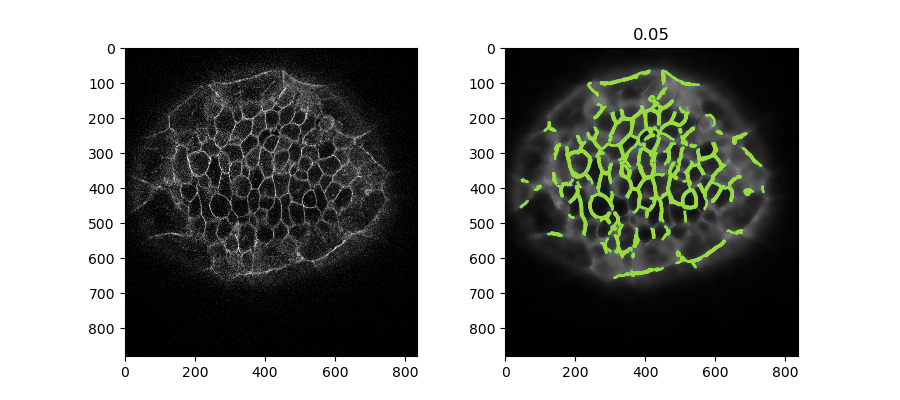

interactive(children=(IntSlider(value=0, description='k', max=59), IntSlider(value=0, description='z', max=16)…

In [3]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import restoration
from skimage import img_as_float
from skimage import feature


k = 1
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

def update(k, z, h, low, high):
    img = image_arrays[0, 0, 0, k, z, :, :, 0]
    for ax_ in ax:
        ax_.cla()
    ax[0].imshow(img, cmap=plt.cm.Greys_r)
    im_float = img_as_float(img)
    im_denoised = restoration.denoise_nl_means(im_float, h=h)
    #distance = ndi.distance_transform_edt(img)
    #local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=img)
    #markers = ndi.label(local_maxi)[0]
    #abels = watershed(-distance, markers, mask=img)
    #ax[1].imshow(labels)
    ax[1].imshow(im_denoised, cmap=plt.cm.Greys_r)   
    
    edges = feature.canny(im_denoised, sigma=0.0, low_threshold=low, high_threshold=high)
    
    ax[1].contour(edges)
    ax[1].set_title(h)
    
widgets.interact(update, k=widgets.IntSlider(min=0, max=59),
                 z=widgets.IntSlider(min=0, max=16),
                 h=widgets.FloatSlider(min=0., max=1., value=0.05, step=0.01),
                 low=widgets.FloatSlider(min=0., max=1., value=0.05, step=0.01),
                 high=widgets.FloatSlider(min=0., max=1., value=0.1, step=0.01));

OpenCV and Mahotas


- https://github.com/luispedro/python-image-tutorial/blob/master/Segmenting%20cell%20images%20(fluorescent%20microscopy).ipynb
- https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476


TODO
- Calibrate h, templateWidowSize and serachWindowSize  (Denoising)
- Calibrate threshold (Thresholding)
- Understand how distances are calculated and what is the watershed marking

<IPython.core.display.Javascript object>


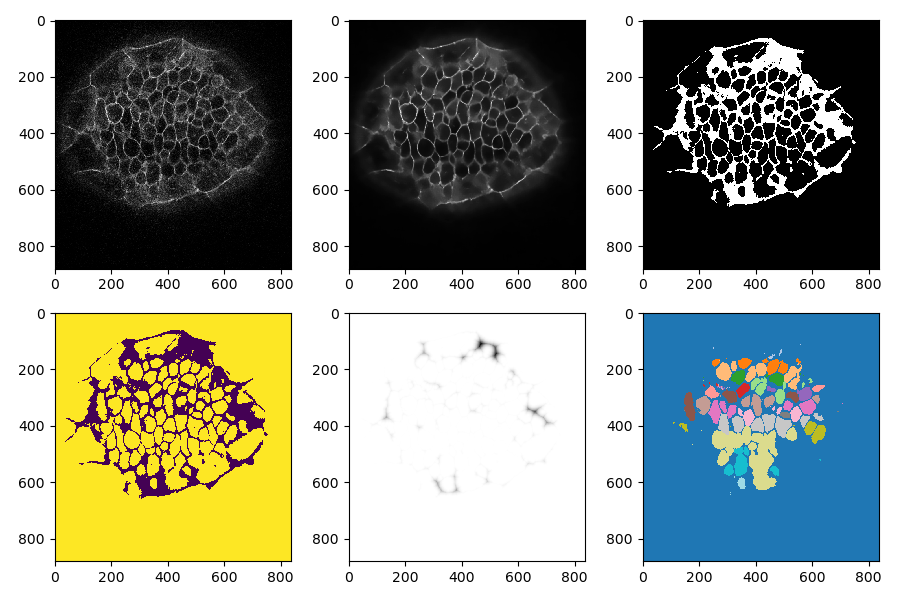

In [125]:
import cv2
import mahotas as mh

fig, ax = plt.subplots(2, 3, figsize=(9, 6), tight_layout=True)

img = image_arrays[0, 0, 0, 0, 0, :, :, 0]
img = ((img/img.max())*255).astype('uint8')
# Original
ax[0, 0].imshow(img, cmap=plt.cm.Greys_r)
# Denoising
dst = cv2.fastNlMeansDenoising(img, None, h=20, templateWindowSize=7, searchWindowSize=21)
ax[0, 1].imshow(dst, cmap=plt.cm.Greys_r)
# Thresholding
binary_mask = dst > 40
ax[0, 2].imshow(binary_mask, cmap=plt.cm.Greys_r)
# Minima
minima = mh.regmin(binary_mask)
markers, nr_markers = mh.label(minima)
ax[1, 0].imshow(minima)
# Distance
dist = mh.distance(binary_mask)
dist = 255 - mh.stretch(dist)
ax[1, 1].imshow(dist, cmap=plt.cm.Greys_r)
# watershed
watershed = mh.cwatershed(dist, markers)
watershed = mh.labeled.remove_bordering(watershed)
ax[1, 2].imshow(watershed, cmap=plt.cm.tab20)
#ax[1, 1].imshow(watershed*binary_mask, cmap=plt.cm.Greys_r)
#ax[1].imshow(im_denoised, cmap=plt.cm.Greys_r)